In [1]:
import pandas as pd
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load your preprocessed dataset
df = pd.read_csv('./Preprocessed/preprocessed_air_quality_data.csv')

# Drop non-numeric and target columns from features
target_col = 'PM10_MAX'
drop_cols = [target_col, 'NAME', 'LASTUPDATEDATETIME', 'timestamp']
drop_cols = [col for col in drop_cols if col in df.columns]
features = df.drop(columns=drop_cols)
target = df[target_col]

print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}")

Features shape: (103205, 23)
Target shape: (103205,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'models/ann_scaler.pkl')

['models/ann_scaler.pkl']

In [5]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

def train_ann_model(X_train_scaled, y_train, input_dim, epochs=50, batch_size=32):
    model = ANN(input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    )
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    torch.save(model.state_dict(), "models/ann_model.pth")
    return model

In [6]:
ann_model = train_ann_model(X_train_scaled, y_train, input_dim=X_train_scaled.shape[1])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_ann_regression(model, X_test_scaled, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
        predictions = model(inputs).numpy().flatten()  # Get predicted values

    # True values (make sure it's a 1D array)
    true_values = y_test

    # Compute metrics
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)

    print(f"ANN Regression Evaluation:")
    print(f" MAE : {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")
    print(f" R²  : {r2:.4f}")

evaluate_ann_regression(ann_model, X_test_scaled, y_test)


ANN Regression Evaluation:
 MAE : 0.0156
 RMSE: 0.0241
 R²  : 0.9893


In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert numpy arrays to PyTorch tensors
X_scaled = scaler.fit_transform(features)
y_np = target.values.reshape(-1, 1)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32)

tscv = TimeSeriesSplit(n_splits=5)

# Store metrics
mae_scores, rmse_scores, r2_scores = [], [], []

# Loop through time series folds
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_tensor)):
    print(f"\nFold {fold+1}")
    X_train_fold, X_test_fold = X_tensor[train_idx], X_tensor[test_idx]
    y_train_fold, y_test_fold = y_tensor[train_idx], y_tensor[test_idx]

    # Model and optimizer
    model = ANN(input_dim=X_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(100):  # Simple fixed epochs
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = criterion(output, y_train_fold)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_fold).numpy().flatten()
        y_true = y_test_fold.numpy().flatten()

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Final averaged results
print("\n🔁 TSCV ANN Evaluation (avg across folds):")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1
MAE: 0.0481, RMSE: 0.0625, R²: 0.9024

Fold 2
MAE: 0.0486, RMSE: 0.0669, R²: 0.8419

Fold 3
MAE: 0.0780, RMSE: 0.1483, R²: 0.3517

Fold 4
MAE: 0.0821, RMSE: 0.1409, R²: 0.5642

Fold 5
MAE: 0.0427, RMSE: 0.0573, R²: 0.9391

🔁 TSCV ANN Evaluation (avg across folds):
Mean MAE: 0.0599 ± 0.0167
Mean RMSE: 0.0952 ± 0.0405
Mean R²: 0.7199 ± 0.2263


In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert numpy arrays to PyTorch tensors
X_scaled = scaler.fit_transform(features)
y_np = target.values.reshape(-1, 1)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32)

tscv = TimeSeriesSplit(n_splits=5)

# Store metrics
mae_scores, rmse_scores, r2_scores = [], [], []

# Loop through time series folds
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_tensor)):
    print(f"\nFold {fold+1}")
    X_train_fold, X_test_fold = X_tensor[train_idx], X_tensor[test_idx]
    y_train_fold, y_test_fold = y_tensor[train_idx], y_tensor[test_idx]

    # Model and optimizer
    model = ANN(input_dim=X_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in range(100):  # Simple fixed epochs
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = criterion(output, y_train_fold)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_fold).numpy().flatten()
        y_true = y_test_fold.numpy().flatten()

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Final averaged results
print("\n🔁 TSCV ANN Evaluation (avg across folds):")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1
MAE: 0.0539, RMSE: 0.0725, R²: 0.8684

Fold 2
MAE: 0.0630, RMSE: 0.0881, R²: 0.7256

Fold 3
MAE: 0.0842, RMSE: 0.1371, R²: 0.4459

Fold 4
MAE: 0.0683, RMSE: 0.1162, R²: 0.7036

Fold 5
MAE: 0.0492, RMSE: 0.0683, R²: 0.9133

🔁 TSCV ANN Evaluation (avg across folds):
Mean MAE: 0.0637 ± 0.0122
Mean RMSE: 0.0965 ± 0.0264
Mean R²: 0.7314 ± 0.1638


In [11]:
torch.save(ann_model.state_dict(), "models/ann_model.pth")

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

In [13]:
# Get predictions
ann_model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
    predictions = ann_model(inputs).numpy().flatten()

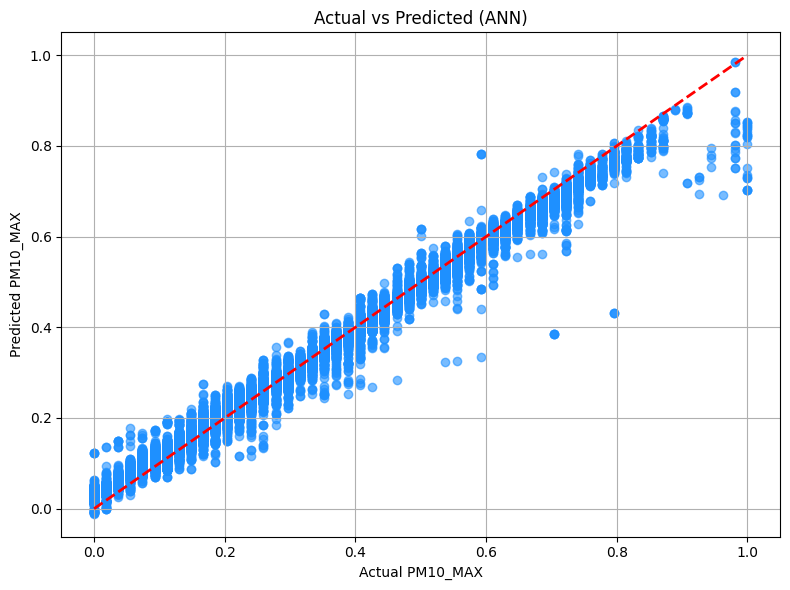

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual PM10_MAX")
plt.ylabel("Predicted PM10_MAX")
plt.title("Actual vs Predicted (ANN)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Get predictions on Train and Test sets
ann_model.eval()
with torch.no_grad():
    # Train predictions
    train_inputs = torch.tensor(X_train_scaled, dtype=torch.float32)
    ann_train_pred = ann_model(train_inputs).numpy().flatten()
    
    # Test/Validation predictions
    test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
    ann_val_pred = ann_model(test_inputs).numpy().flatten()

# Step 2: Define and apply regression metrics
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

ann_train_metrics = regression_metrics(y_train, ann_train_pred)
ann_val_metrics = regression_metrics(y_test, ann_val_pred)

# Step 3: Create and print tabulated results
ann_metrics_df = pd.DataFrame({
    'MAE': [ann_train_metrics[0], ann_val_metrics[0]],
    'RMSE': [ann_train_metrics[1], ann_val_metrics[1]],
    'R² Score': [ann_train_metrics[2], ann_val_metrics[2]]
}, index=['Train', 'Validation'])

print("\n📊 ANN Performance Metrics:")
print(tabulate(ann_metrics_df.round(4), headers='keys', tablefmt='pretty'))



📊 ANN Performance Metrics:
+------------+--------+--------+----------+
|            |  MAE   |  RMSE  | R² Score |
+------------+--------+--------+----------+
|   Train    | 0.019  | 0.0264 |  0.9869  |
| Validation | 0.0191 | 0.027  |  0.9865  |
+------------+--------+--------+----------+
